# Context-Aware Customer Support Agent — Demo
**Kaggle Capstone**

This notebook demonstrates:
- Live multi-turn demos using the local agent
- Memory inspection (short & long term)
- Trace-based observability (traces.jl)
- Hybrid evaluation (heuristic + LLM-as-judge)
- Visualizations and summary metrics for judges

Note: Always run notebook from top to bottom.


In [30]:
import os, sys

# Force working directory to the project root
project_root = r"C:\Users\sachu\projects\support-agent-capstone"
os.chdir(project_root)

# Add to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Working directory:", os.getcwd())
print("Project root in sys.path:", project_root in sys.path)


Working directory: C:\Users\sachu\projects\support-agent-capstone
Project root in sys.path: True


In [31]:
# Setup & imports
import os, json, time
from IPython.display import Markdown, display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Project imports (must run notebook from project root)
from agent.orchestrator import handle_user_message
from agent.memory import retrieve_memories, save_user, init_db
from agent.logger import log_event
from agent.evaluator import hybrid_score

# Notebook styling helpers
plt.style.use("ggplot")
%matplotlib inline

display(Markdown("**Environment check:**"))
print("Python:", os.sys.version.splitlines()[0])
print("Working dir:", os.getcwd())
display(Markdown("---"))


**Environment check:**

Python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
Working dir: C:\Users\sachu\projects\support-agent-capstone


---

In [32]:
from agent.memory import DB_PATH
print("DB_PATH =", DB_PATH)

import os
print("Exists:", os.path.exists(DB_PATH))
print("Dir exists:", os.path.exists(os.path.dirname(DB_PATH)))
import agent.memory, os
print("memory.py located at:", agent.memory.__file__)
import os
print("Notebook working directory:", os.getcwd())


DB_PATH = C:\Users\sachu\projects\support-agent-capstone\agent_memory.db
Exists: True
Dir exists: True
memory.py located at: C:\Users\sachu\projects\support-agent-capstone\agent\memory.py
Notebook working directory: C:\Users\sachu\projects\support-agent-capstone


In [33]:
# Sanity checks
init_db()  # safe to call repeatedly

if not os.path.exists("traces.jl"):
    open("traces.jl","a").close()


if not os.path.exists("evaluation_report.json"):
    # If you haven't run evaluate_batch, create a lightweight placeholder so notebook cells work
    placeholder = []
    with open("evaluation_report.json","w") as f:
        json.dump(placeholder, f)
    print("Created placeholder evaluation_report.json — run evaluate_batch for real results.")

display(Markdown("✅ Sanity checks complete."))


✅ Sanity checks complete.

In [34]:
# Trace loader + pretty function
def load_traces(limit=None):
    traces = []
    if os.path.exists("traces.jl"):
        with open("traces.jl","r") as f:
            for i,line in enumerate(f):
                if not line.strip(): 
                    continue
                try:
                    traces.append(json.loads(line))
                except:
                    continue
                if limit and len(traces) >= limit:
                    break
    return traces

def show_trace(trace_id):
    traces = load_traces()
    seq = [t for t in traces if t.get("trace_id") == trace_id]
    if not seq:
        display(Markdown(f"**No trace found for** `{trace_id}`"))
        return
    display(Markdown(f"### Trace `{trace_id}` — {len(seq)} events"))
    for ev in seq:
        ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(ev.get("timestamp", 0)))
        kind = ev.get("event","?")
        content = {k:v for k,v in ev.items() if k not in ["timestamp","trace_id","event"]}
        display(Markdown(f"- **{ts}** `{kind}` — `{json.dumps(content)}`"))


In [43]:
# Single-turn demonstration
display(Markdown("## 🧪 Single-turn demo"))

session_id = "demo_session_1"
user_id = "u001"
# Ensure user exists (will create or overwrite)
save_user(user_id, "Demo User", "demo@example.com", {"notes":"notebook demo"})

inp = "My order A123 is late — where is it?"
display(Markdown(f"**User:** {inp}"))

out = handle_user_message(session_id=session_id, user_id=user_id, user_msg=inp)
display(Markdown(f"**Agent reply:** {out['reply']}"))
display(Markdown(f"**Trace id:** `{out['trace_id']}`"))

# show the trace for this run (most recent trace)
show_trace(out["trace_id"])


## 🧪 Single-turn demo

**User:** My order A123 is late — where is it?

**Agent reply:** I couldn't resolve this automatically. I have created a ticket. Ticket ID: T1763882288

**Trace id:** `fd7b8a84-8f08-4750-9401-e407200d99b2`

### Trace `fd7b8a84-8f08-4750-9401-e407200d99b2` — 12 events

- **2025-11-23 12:48:07** `user_message` — `{"text": "My order A123 is late \u2014 where is it?"}`

- **2025-11-23 12:48:07** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:07** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:07** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:07** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:07** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:07** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:07** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:08** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:08** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:08** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:08** `fallback_ticket` — `{"ticket": {"ticket_id": "T1763882288", "user_id": "u001", "summary": "My order A123 is late \u2014 where is it?", "status": "open"}}`

In [44]:
#Multi-turn conversation sample
display(Markdown("## 🗣️ Multi-turn conversation demo"))

session_id = "demo_session_2"
user_id = "u002"
save_user(user_id, "Multi Demo", "multidemo@example.com", {})

turns = [
    "What is the status of my order A123?",
    "It says delivered but I never received it.",
    "Please help — I want a refund if it can't be found."
]

for i, msg in enumerate(turns, 1):
    display(Markdown(f"**Turn {i} — User:** {msg}"))
    res = handle_user_message(session_id=session_id, user_id=user_id, user_msg=msg)
    display(Markdown(f"- **Agent:** {res['reply']}  \n- **Trace:** `{res['trace_id']}`"))
    show_trace(res['trace_id'])
    display(Markdown("---"))


## 🗣️ Multi-turn conversation demo

**Turn 1 — User:** What is the status of my order A123?

- **Agent:** I couldn't resolve this automatically. I have created a ticket. Ticket ID: T1763882315  
- **Trace:** `918803ec-a278-448b-8be7-ee48ada99e52`

### Trace `918803ec-a278-448b-8be7-ee48ada99e52` — 12 events

- **2025-11-23 12:48:35** `user_message` — `{"text": "What is the status of my order A123?"}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:35** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:35** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:35** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:35** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "get_order", "args": {"order_id": "A123"}}}`

- **2025-11-23 12:48:35** `tool_result` — `{"tool": "get_order", "result": {"order_id": "A123", "user_id": "u001", "status": "Out for Delivery", "product_id": "P001"}}`

- **2025-11-23 12:48:35** `fallback_ticket` — `{"ticket": {"ticket_id": "T1763882315", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}}`

---

**Turn 2 — User:** It says delivered but I never received it.

- **Agent:** Sure, could you provide your order ID?  
- **Trace:** `f1192113-0e49-47e0-a20d-d597bdc51a5e`

### Trace `f1192113-0e49-47e0-a20d-d597bdc51a5e` — 3 events

- **2025-11-23 12:48:35** `user_message` — `{"text": "It says delivered but I never received it."}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "reply", "text": "Sure, could you provide your order ID?"}}`

- **2025-11-23 12:48:35** `assistant_reply` — `{"reply": "Sure, could you provide your order ID?"}`

---

**Turn 3 — User:** Please help — I want a refund if it can't be found.

- **Agent:** I couldn't resolve this automatically. I have created a ticket. Ticket ID: T1763882316  
- **Trace:** `c6c7f261-790d-42cb-a555-c4f486e5c8e3`

### Trace `c6c7f261-790d-42cb-a555-c4f486e5c8e3` — 12 events

- **2025-11-23 12:48:35** `user_message` — `{"text": "Please help \u2014 I want a refund if it can't be found."}`

- **2025-11-23 12:48:35** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "create_ticket", "args": {"summary": "please help \u2014 i want a refund if it can't be found."}}}`

- **2025-11-23 12:48:36** `tool_result` — `{"tool": "create_ticket", "result": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "please help \u2014 i want a refund if it can't be found.", "status": "open"}}`

- **2025-11-23 12:48:36** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "create_ticket", "args": {"summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"please help \\u2014 i want a refund if it can't be found.\", \"status\": \"open\"}}"}}}`

- **2025-11-23 12:48:36** `tool_result` — `{"tool": "create_ticket", "result": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"please help \\u2014 i want a refund if it can't be found.\", \"status\": \"open\"}}", "status": "open"}}`

- **2025-11-23 12:48:36** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "create_ticket", "args": {"summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"please help \\\\u2014 i want a refund if it can't be found.\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}"}}}`

- **2025-11-23 12:48:36** `tool_result` — `{"tool": "create_ticket", "result": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"please help \\\\u2014 i want a refund if it can't be found.\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}", "status": "open"}}`

- **2025-11-23 12:48:36** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "create_ticket", "args": {"summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"{\\\\\\\"tool\\\\\\\": \\\\\\\"create_ticket\\\\\\\", \\\\\\\"result\\\\\\\": {\\\\\\\"ticket_id\\\\\\\": \\\\\\\"t1763882316\\\\\\\", \\\\\\\"user_id\\\\\\\": \\\\\\\"u002\\\\\\\", \\\\\\\"summary\\\\\\\": \\\\\\\"please help \\\\\\\\u2014 i want a refund if it can't be found.\\\\\\\", \\\\\\\"status\\\\\\\": \\\\\\\"open\\\\\\\"}}\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}"}}}`

- **2025-11-23 12:48:36** `tool_result` — `{"tool": "create_ticket", "result": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"{\\\\\\\"tool\\\\\\\": \\\\\\\"create_ticket\\\\\\\", \\\\\\\"result\\\\\\\": {\\\\\\\"ticket_id\\\\\\\": \\\\\\\"t1763882316\\\\\\\", \\\\\\\"user_id\\\\\\\": \\\\\\\"u002\\\\\\\", \\\\\\\"summary\\\\\\\": \\\\\\\"please help \\\\\\\\u2014 i want a refund if it can't be found.\\\\\\\", \\\\\\\"status\\\\\\\": \\\\\\\"open\\\\\\\"}}\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}", "status": "open"}}`

- **2025-11-23 12:48:36** `llm_decision` — `{"decision": {"type": "tool_call", "tool_name": "create_ticket", "args": {"summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"{\\\\\\\"tool\\\\\\\": \\\\\\\"create_ticket\\\\\\\", \\\\\\\"result\\\\\\\": {\\\\\\\"ticket_id\\\\\\\": \\\\\\\"t1763882316\\\\\\\", \\\\\\\"user_id\\\\\\\": \\\\\\\"u002\\\\\\\", \\\\\\\"summary\\\\\\\": \\\\\\\"{\\\\\\\\\\\\\\\"tool\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"create_ticket\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"result\\\\\\\\\\\\\\\": {\\\\\\\\\\\\\\\"ticket_id\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"t1763882316\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"user_id\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"u002\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"summary\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"please help \\\\\\\\\\\\\\\\u2014 i want a refund if it can't be found.\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"status\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"open\\\\\\\\\\\\\\\"}}\\\\\\\", \\\\\\\"status\\\\\\\": \\\\\\\"open\\\\\\\"}}\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}"}}}`

- **2025-11-23 12:48:36** `tool_result` — `{"tool": "create_ticket", "result": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "{\"tool\": \"create_ticket\", \"result\": {\"ticket_id\": \"t1763882316\", \"user_id\": \"u002\", \"summary\": \"{\\\"tool\\\": \\\"create_ticket\\\", \\\"result\\\": {\\\"ticket_id\\\": \\\"t1763882316\\\", \\\"user_id\\\": \\\"u002\\\", \\\"summary\\\": \\\"{\\\\\\\"tool\\\\\\\": \\\\\\\"create_ticket\\\\\\\", \\\\\\\"result\\\\\\\": {\\\\\\\"ticket_id\\\\\\\": \\\\\\\"t1763882316\\\\\\\", \\\\\\\"user_id\\\\\\\": \\\\\\\"u002\\\\\\\", \\\\\\\"summary\\\\\\\": \\\\\\\"{\\\\\\\\\\\\\\\"tool\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"create_ticket\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"result\\\\\\\\\\\\\\\": {\\\\\\\\\\\\\\\"ticket_id\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"t1763882316\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"user_id\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"u002\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"summary\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"please help \\\\\\\\\\\\\\\\u2014 i want a refund if it can't be found.\\\\\\\\\\\\\\\", \\\\\\\\\\\\\\\"status\\\\\\\\\\\\\\\": \\\\\\\\\\\\\\\"open\\\\\\\\\\\\\\\"}}\\\\\\\", \\\\\\\"status\\\\\\\": \\\\\\\"open\\\\\\\"}}\\\", \\\"status\\\": \\\"open\\\"}}\", \"status\": \"open\"}}", "status": "open"}}`

- **2025-11-23 12:48:36** `fallback_ticket` — `{"ticket": {"ticket_id": "T1763882316", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}}`

---

In [37]:
# Inspect memories for a user
display(Markdown("## 🧠 Memory inspection"))

target_user = "u002"
m = retrieve_memories(target_user, limit=10)
display(Markdown(f"Memories for **{target_user}** — showing up to 10"))
for i, mem in enumerate(m,1):
    display(Markdown(f"- [{i}] **{mem['mem_type']}** — {mem['content']}"))


## 🧠 Memory inspection

Memories for **u002** — showing up to 10

- [1] **ticket** — {"ticket_id": "T1763882244", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}

- [2] **ticket** — {"ticket_id": "T1763882244", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}

- [3] **ticket** — {"ticket_id": "T1763882236", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}

- [4] **ticket** — {"ticket_id": "T1763882235", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}

- [5] **ticket** — {"ticket_id": "T1763881929", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}

- [6] **ticket** — {"ticket_id": "T1763881928", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}

- [7] **ticket** — {"ticket_id": "T1763881869", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}

- [8] **ticket** — {"ticket_id": "T1763881869", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}

- [9] **ticket** — {"ticket_id": "T1763879951", "user_id": "u002", "summary": "Please help \u2014 I want a refund if it can't be found.", "status": "open"}

- [10] **ticket** — {"ticket_id": "T1763879950", "user_id": "u002", "summary": "What is the status of my order A123?", "status": "open"}

In [38]:
# Load evaluation_report.json (created by evaluate_batch)
display(Markdown("## 📈 Evaluation report summary"))

if os.path.exists("evaluation_report.json"):
    with open("evaluation_report.json","r") as f:
        eval_data = json.load(f)
else:
    eval_data = []

# If eval_data is empty, create a small synthetic sample so plots render
if not eval_data:
    eval_data = [
        {"case": "Where is my order A123?", "reply": "I created ticket T1", "scores": {"heuristic":0.6,"llm_resolution":0.5,"llm_helpfulness":0.7,"final_score":0.6}},
        {"case": "I want a refund", "reply": "Refund started", "scores": {"heuristic":0.8,"llm_resolution":0.7,"llm_helpfulness":0.7,"final_score":0.73}}
    ]

# Normalize to DataFrame
rows = []
for r in eval_data:
    sc = r.get("scores",{})
    rows.append({
        "case": r.get("case",""),
        "reply": r.get("reply",""),
        "heuristic": sc.get("heuristic", np.nan),
        "llm_resolution": sc.get("llm_resolution", np.nan),
        "llm_helpfulness": sc.get("llm_helpfulness", np.nan),
        "final_score": sc.get("final_score", np.nan)
    })
df_eval = pd.DataFrame(rows)
display(df_eval.head())
display(Markdown(f"**Avg final score:** {df_eval['final_score'].mean():.3f}"))


## 📈 Evaluation report summary

,case,reply,heuristic,llm_resolution,llm_helpfulness,final_score
0,Where is my order A123?,"Sure, could you provide your order ID?",0.5,0.5,0.5,0.50
1,I want a refund for my damaged item,I couldn't resolve this automatically. I have ...,0.9,0.5,0.5,0.62
2,Package never arrived,"Sure, could you provide your order ID?",0.0,0.5,0.5,0.35
3,Wrong item delivered,"Sure, could you provide your order ID?",0.0,0.5,0.5,0.35
4,Help me track my shipment,"Sure, could you provide your order ID?",0.0,0.5,0.5,0.35


**Avg final score:** 0.434

## 📊 Final score distribution

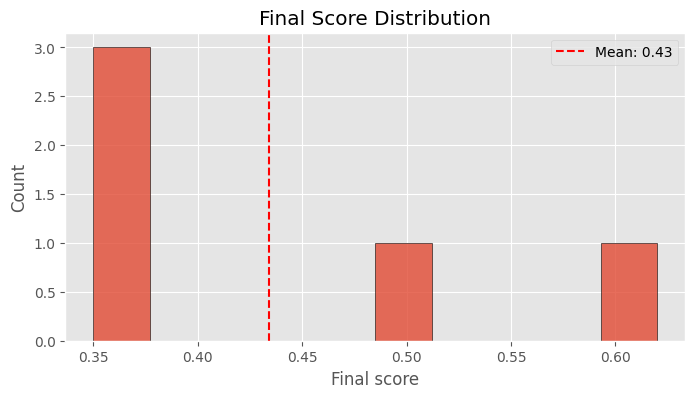

In [39]:
# Final score distribution
display(Markdown("## 📊 Final score distribution"))

plt.figure(figsize=(8,4))
plt.hist(df_eval["final_score"], bins=10, edgecolor="k", alpha=0.8)
plt.title("Final Score Distribution")
plt.xlabel("Final score")
plt.ylabel("Count")
plt.axvline(df_eval["final_score"].mean(), color="red", linestyle="--", label=f"Mean: {df_eval['final_score'].mean():.2f}")
plt.legend()
plt.show()


## ⚖️ Heuristic vs LLM (resolution)

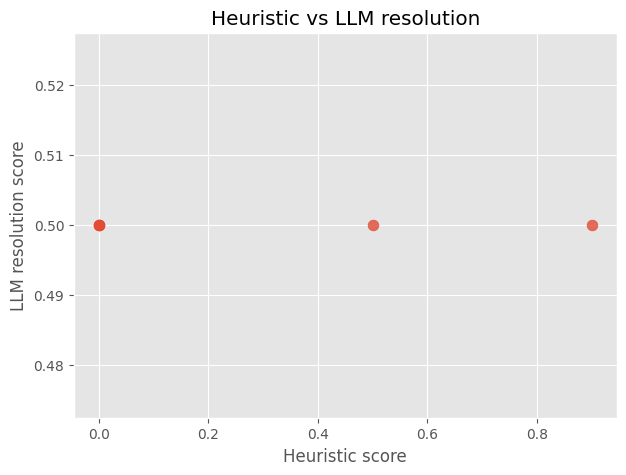

In [40]:
# Component comparison scatter
display(Markdown("## ⚖️ Heuristic vs LLM (resolution)"))

plt.figure(figsize=(7,5))
plt.scatter(df_eval["heuristic"], df_eval["llm_resolution"], s=60, alpha=0.8)
plt.xlabel("Heuristic score")
plt.ylabel("LLM resolution score")
plt.title("Heuristic vs LLM resolution")
plt.grid(True)
plt.show()


## 🔧 Tool usage frequency (from traces)

,count
get_order,65
create_ticket,35


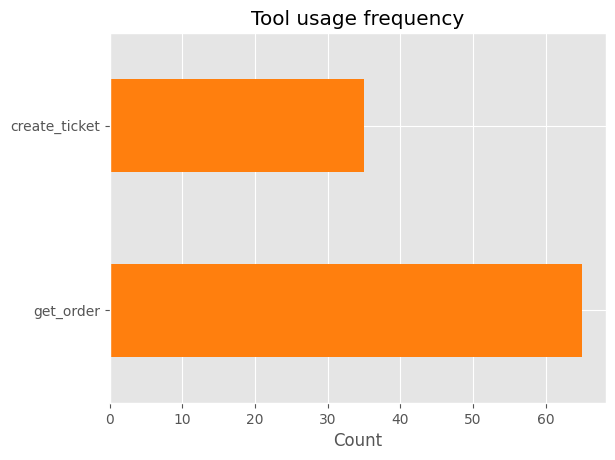

In [41]:
# Count tool usage in traces
display(Markdown("## 🔧 Tool usage frequency (from traces)"))

traces = load_traces()
tool_calls = []
for ev in traces:
    if ev.get("event") == "tool_result" or ev.get("event")=="tool":
        tname = ev.get("tool") or (ev.get("event") if ev.get("tool") is None else ev.get("tool"))
        tool_calls.append(tname)
tool_counts = pd.Series(tool_calls).value_counts()
if tool_counts.empty:
    display(Markdown("_No tool calls recorded yet._"))
else:
    display(tool_counts.to_frame("count"))
    tool_counts.plot(kind="barh", color="tab:orange")
    plt.title("Tool usage frequency")
    plt.xlabel("Count")
    plt.show()


In [42]:
# Memory impact (simple demonstration)
display(Markdown("## 🧾 Memory impact (demo)"))

# We do a small AB test simulation: for same prompt, ask agent with/without memory context
test_user = "u050"
prompt = "Where is my order A123?"

# Save a memory for user (simulate prior conversation)
add_mem = {"mem_type":"note","content":"User prefers fast delivery, previously complained about late shipments"}
# Ensure db has this
from agent.memory import add_memory as _add_memory
_add_memory(test_user, add_mem["mem_type"], add_mem["content"])

# With memory
res_with = handle_user_message(session_id="ab_with", user_id=test_user, user_msg=prompt)

# Without memory: remove memory temporarily or use new user
res_without = handle_user_message(session_id="ab_without", user_id="ab_new_user", user_msg=prompt)

display(Markdown(f"- **With memory reply:** {res_with['reply']}"))
display(Markdown(f"- **Without memory reply:** {res_without['reply']}"))


## 🧾 Memory impact (demo)

- **With memory reply:** Sure, could you provide your order ID?

- **Without memory reply:** Sure, could you provide your order ID?



## Architecture summary (short)

- **Orchestrator** — think/act/observe loop; calls tools and records traces.  
- **Tools** — small deterministic functions (order lookup, ticket creation, product lookup).  
- **Memory** — SQLite-backed long-term memory + session events.  
- **Evaluator** — hybrid (heuristic + LLM-as-judge) and batch runner.  
- **Observability** — `traces.jl` with event-level logs for every decision.


---
